<a href="https://colab.research.google.com/github/stepan-zykov/portfolio/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook
from matplotlib.colors import Normalize
import IPython.display as display
from math import ceil

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/MyDrive/DLS/HW/HW7_AutoEncoder/')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/DLS/HW/HW7_AutoEncoder'

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    print('started builing dataframe')
    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    print('1')

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})
    print('2')
    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))
    print('3')
    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    print('4')

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))


    print('5')
    all_photos = np.stack(all_photos.values)#.astype('uint8')
    print('6')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

Загрузим данные

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

Разобьем данные на обучающую и валидационную выборки

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.1, shuffle=False)

Посмотрим на фотографии

In [ ]:
def show_pictures(pictures):
    rows = ceil(len(pictures)/5)
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.flatten()
    for i, photo in enumerate(pictures):
        axes[i].imshow(photo)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
show_pictures(train_photos[:5])

Реализуем автоэнкодер с собственной архитектурой

In [ ]:
latent_features = 20
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=64*64*3, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64*64*3)
        )

    def forward(self, x):
        x = self.flatten(x).float()
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

    def sample(self, z):
        z = z.float()
        generated = self.decoder(z)
        return generated

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        latent = self.encoder(x)
        return latent

## 1.3 Обучение

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = F.mse_loss
autoencoder = AutoEncoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=5, )
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=5)

In [ ]:
def compare_pictures(gt, rec):
    '''
    Функция выводит исходные картинки и выходы AE одну над другой
    '''
    rec = rec.view(-1, 64, 64, 3).cpu().detach().numpy()
    gt = gt.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(8, 3))
    axes = axes.flatten()
    for i, photo in enumerate(np.concatenate([gt, rec])):
        photo = np.clip(photo, 0, 1)
        axes[i].imshow(photo)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def losses_chart(train_losses, val_losses):
    '''
    Отрисовка графиков лоссов
    '''
    epoch = len(train_losses)
    plt.plot(range(1, epoch + 1), train_losses, label = 'Training Loss')
    plt.plot(range(1, epoch + 1), val_losses, label = 'Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=10):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            X_batch = X_batch.float().to(device)
            optimizer.zero_grad()
            latent, reconstructed = model(X_batch)
            loss = loss_fn(reconstructed, X_batch.view(-1, 64*64*3))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
          for X_batch in val_loader:
              X_batch = X_batch.float().to(device)
              latent, reconstructed = model(X_batch)
              loss = loss_fn(reconstructed, X_batch.view(-1, 64*64*3))
              val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

        display.clear_output(wait=True) # clear previous output
        compare_pictures(X_batch, reconstructed)
        losses_chart(train_losses, val_losses)
        print(f"Epoch [{epoch + 1}/{n_epochs}],",
              f"\nTraining loss: {np.mean(train_losses_per_epoch):.4f},",
              f"\nValidation loss: {np.mean(val_losses_per_epoch):.4f}")

    return train_losses, val_losses

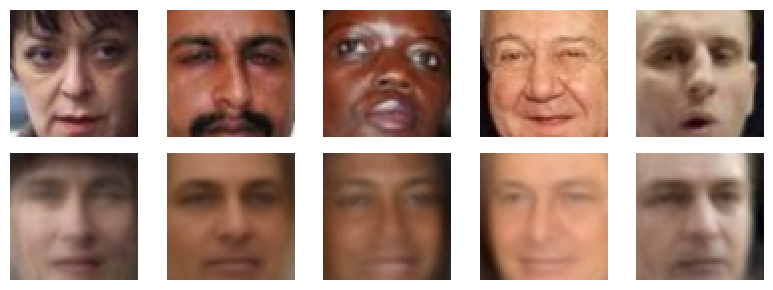

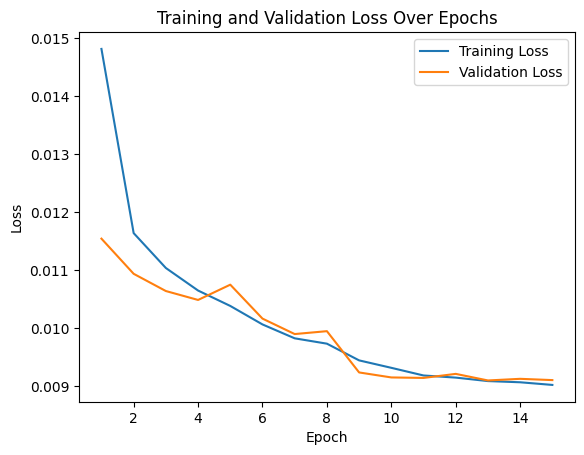

Epoch [15/15], 
Training loss: 0.0090, 
Validation loss: 0.0091


In [ ]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, train_loader, val_loader, n_epochs=15)

В целом 15 эпох хватилот для обучения модели. Дальнейшего улучшения качества можно добиться усовершенствование архитектуры или изменением размерности латентного слоя

In [ ]:
torch.save(autoencoder, 'autoencoder.pt')

In [ ]:
autoencoder = torch.load('autoencoder.pt').to(device)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

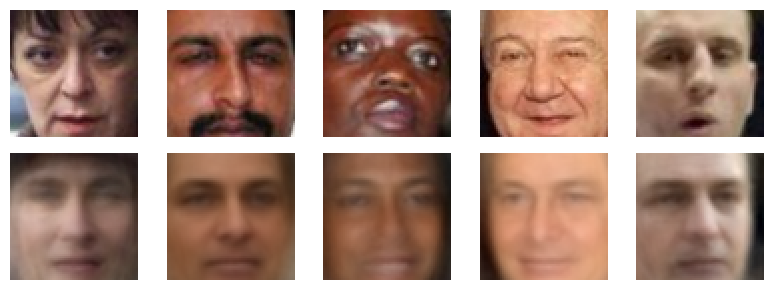

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
        latent, reconstructed = autoencoder(batch.to(device))

compare_pictures(batch, reconstructed)

## 1.4. Sampling

Подадим на вход декодера случайно сгенерированные из нормального распределения векторы

In [ ]:
z = torch.tensor(np.random.rand(25, latent_features)).cuda()
output = autoencoder.sample(z).view(-1, 64, 64, 3).cpu().detach().clip(0, 1)

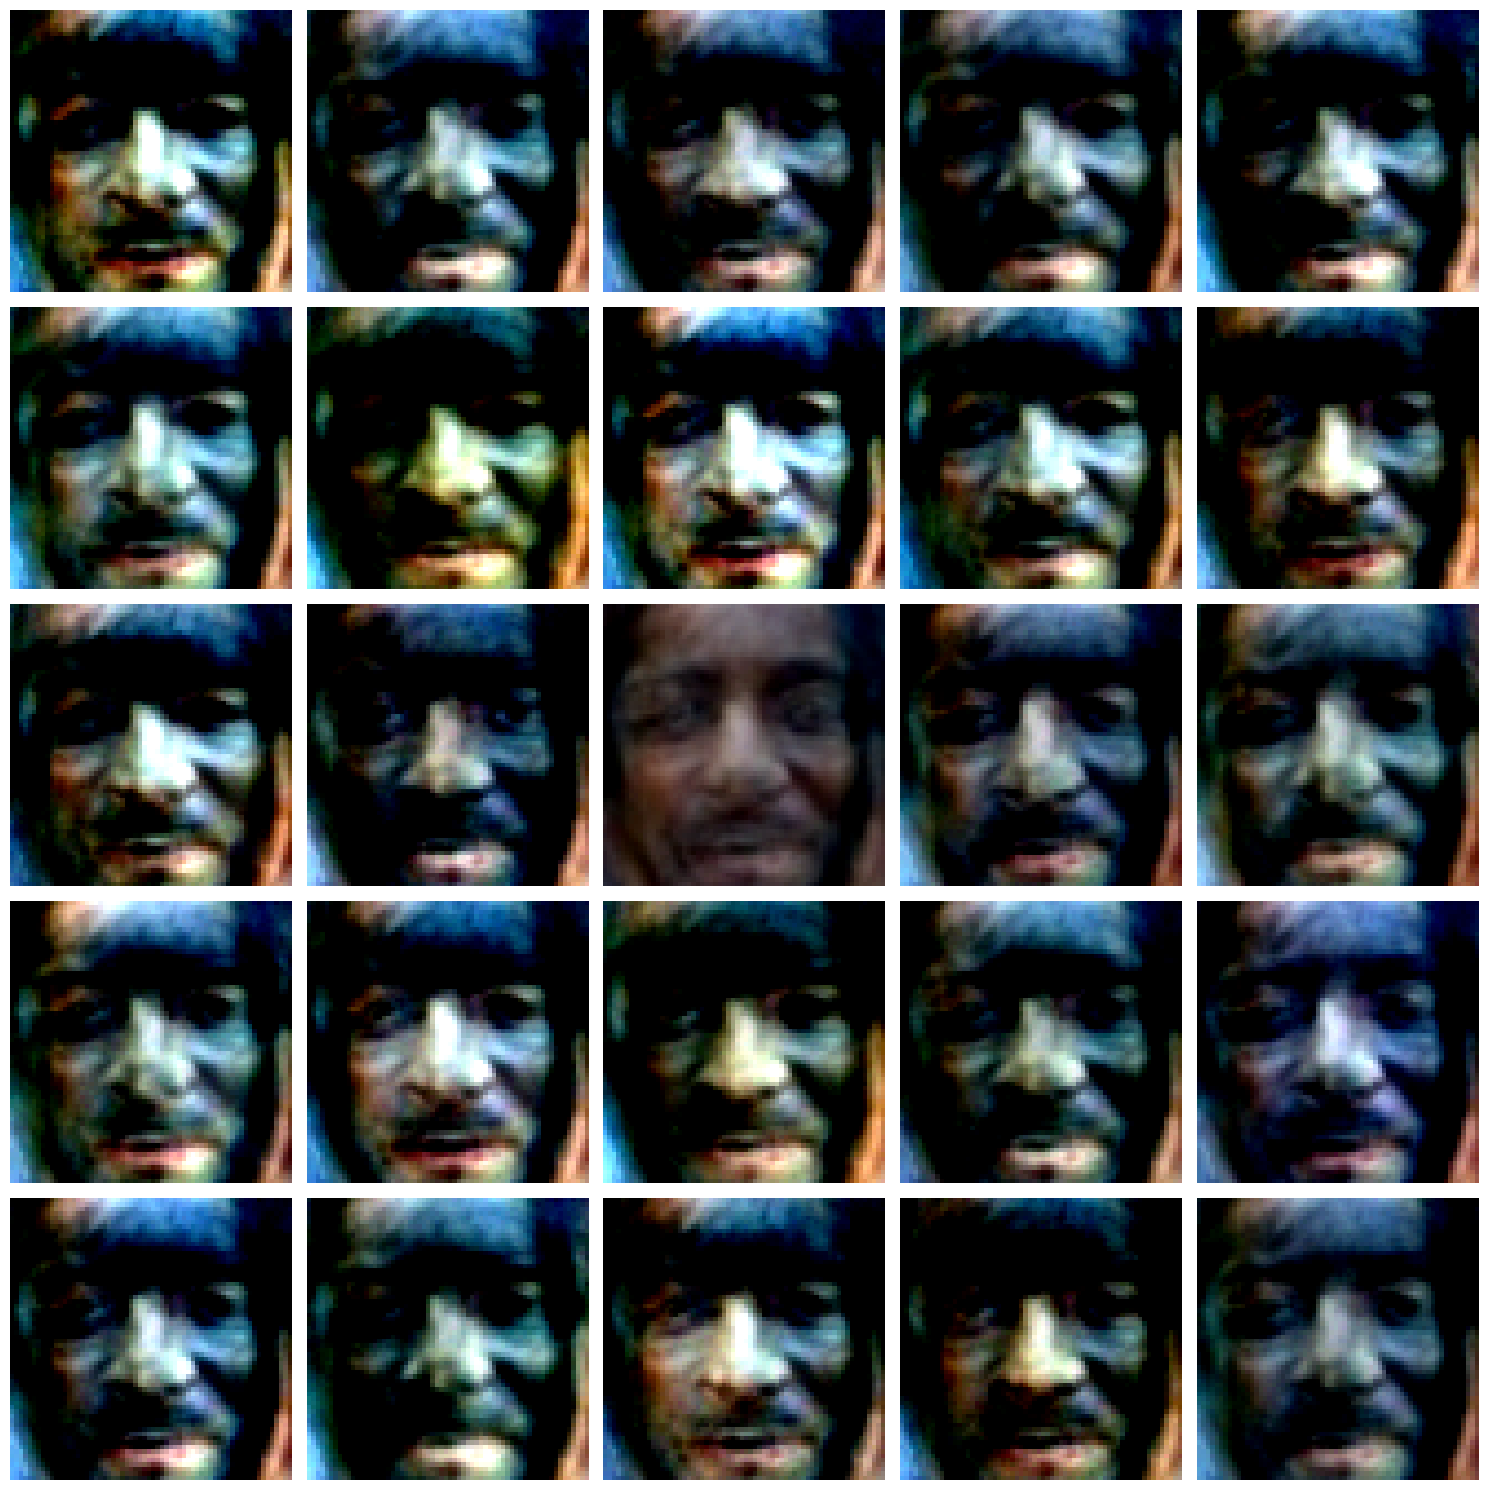

In [ ]:
show_pictures(output)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

Найдем из выборки изображений несколько улыбающихся и несколько неулыбающихся мужчин без усов (так мы получим лучшие результаты)

In [ ]:
train_attrs[(train_attrs['Mustache'] < -1.5) & (train_attrs['Male'] > 1)].shape

(22, 73)

In [ ]:
smiling_idxs = train_attrs[(train_attrs['Mustache'] < -1.5) & (train_attrs['Male'] > 1)]['Smiling'].sort_values(ascending=False)[:15].index
not_smiling_idxs = train_attrs[(train_attrs['Mustache'] < -1.5) & (train_attrs['Male'] > 1)]['Smiling'].sort_values(ascending=True)[:15].index

In [ ]:
smiling_photos = train_photos[smiling_idxs]

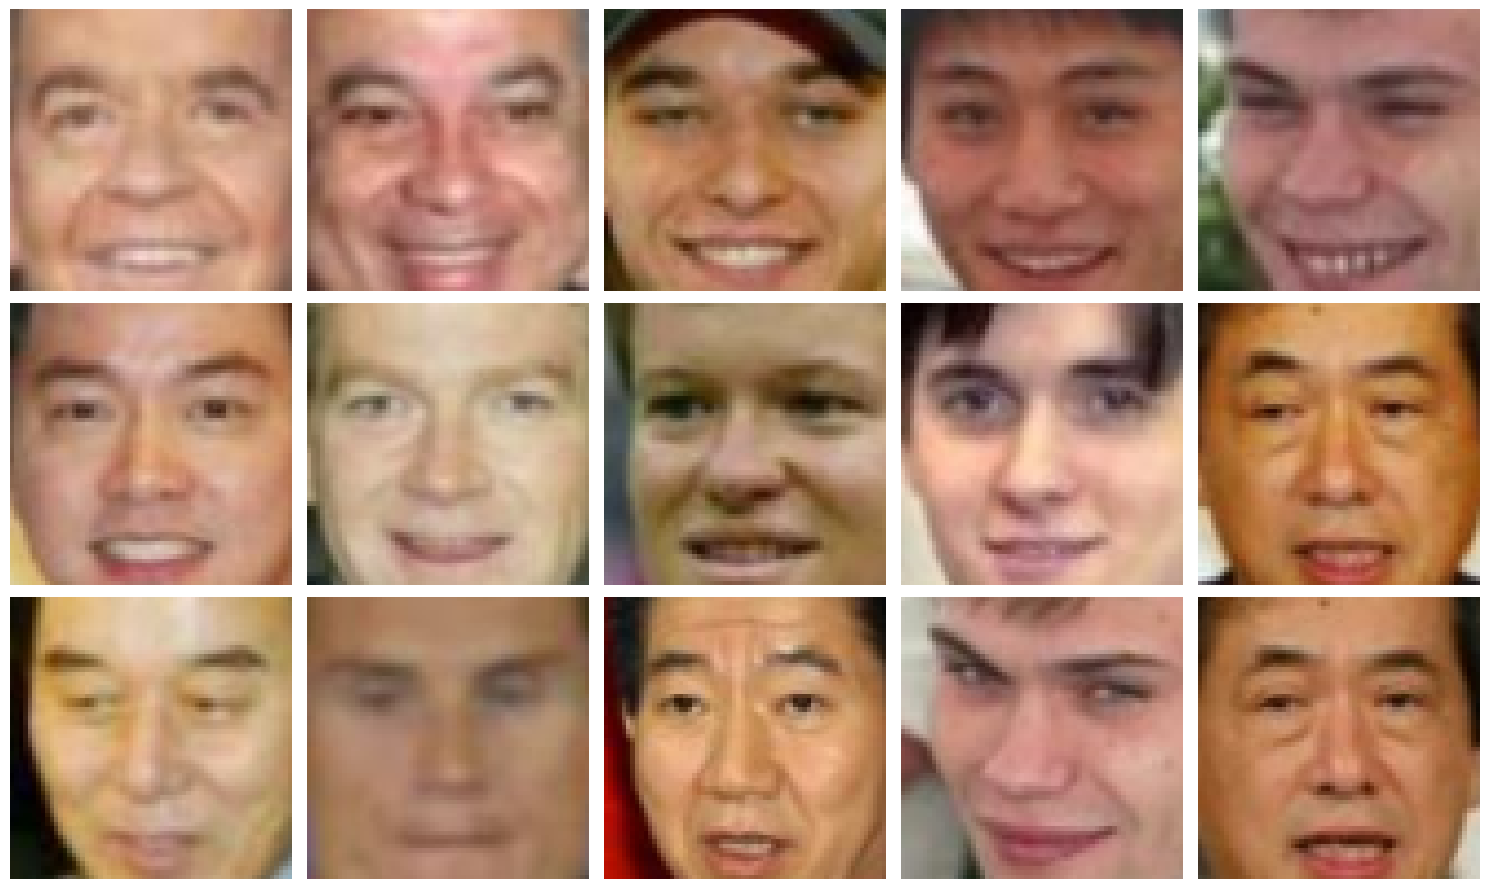

In [ ]:
show_pictures(smiling_photos)

In [ ]:
not_smiling_photos = train_photos[not_smiling_idxs]

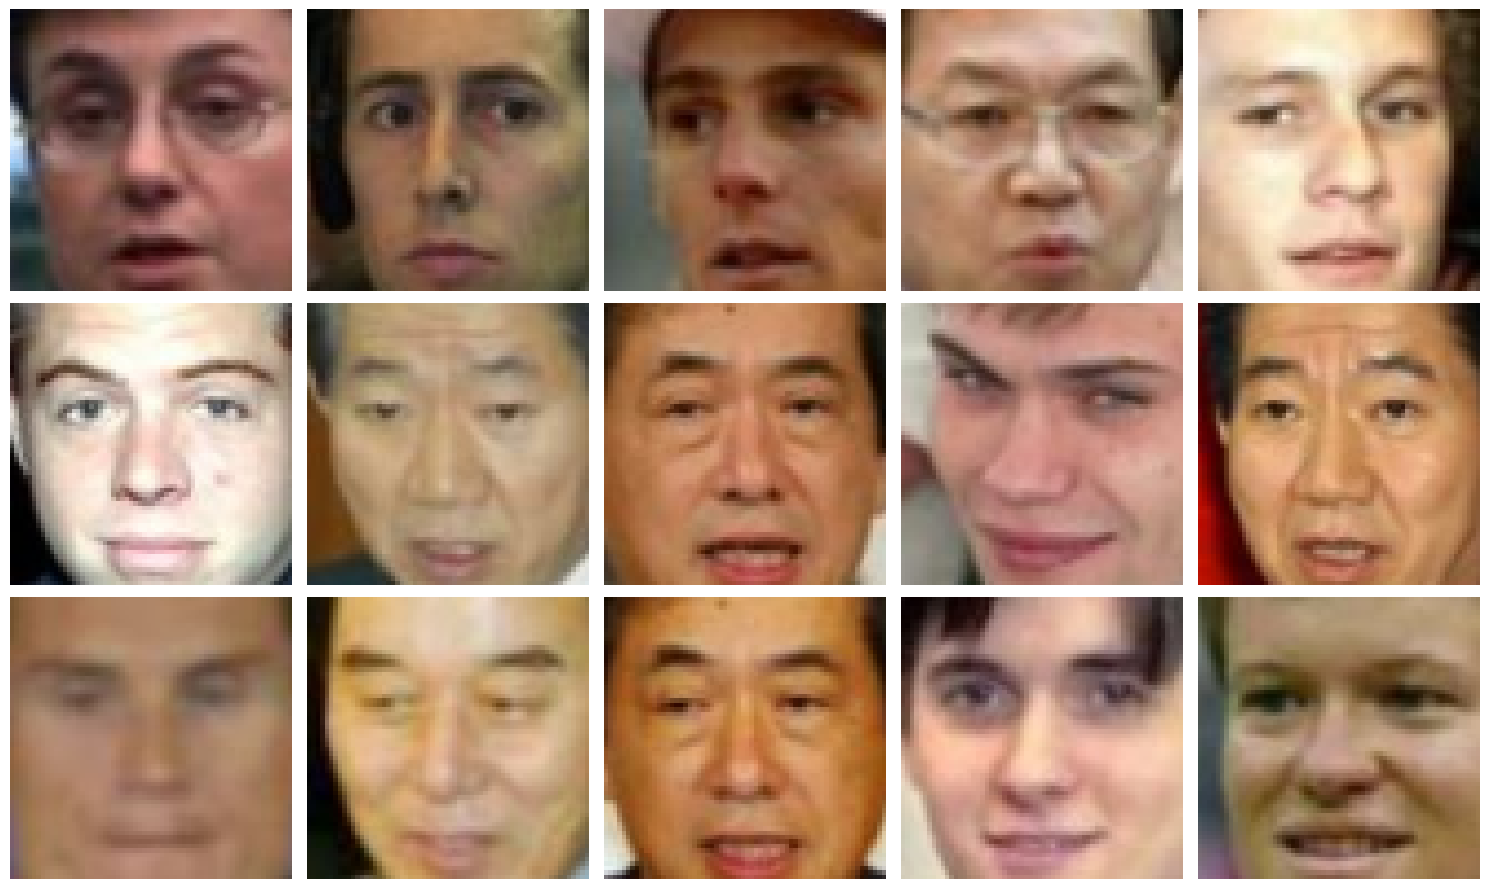

In [ ]:
show_pictures(not_smiling_photos)

Прибавим "вектор улыбки" к картинкам с неулыбающимися людьми и посмотрим на результат

In [ ]:
smiling_photos = torch.tensor(smiling_photos).to(device)
not_smiling_photos = torch.tensor(not_smiling_photos).to(device)
autoencoder.eval()
with torch.no_grad():
    smiling_latent = autoencoder.get_latent_vector(smiling_photos)
    not_smiling_latent = autoencoder.get_latent_vector(not_smiling_photos)
    smile_delta = smiling_latent.mean(axis=0) - not_smiling_latent.mean(axis=0)
    make_smile = not_smiling_latent + smile_delta
    generated = autoencoder.sample(make_smile)

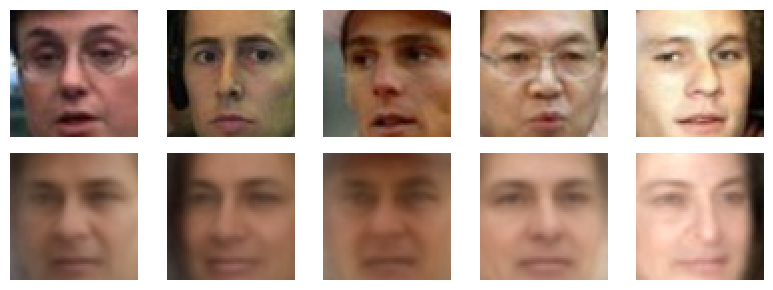

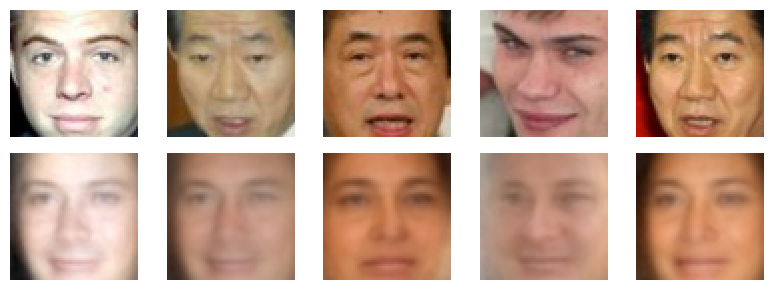

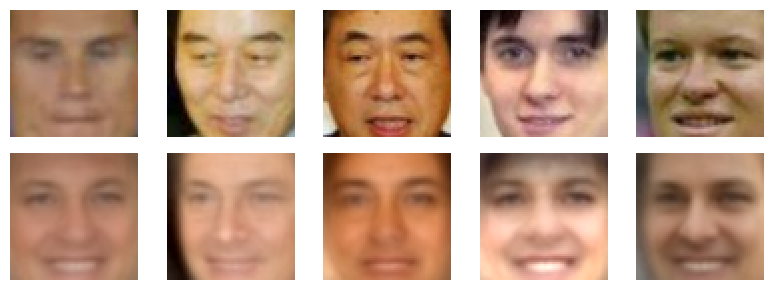

In [ ]:
for i in range(0, 11, 5):
    compare_pictures(not_smiling_photos[i:i+5], generated[i:i+5])

# 2.1 Variational AE

Загружаем датасет MNIST, преобразуем данные в PyTorch тензоры

In [ ]:
batch_size = 60
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def compare_pictures_vae(gt, rec):
    """
    Функция получает на вход ихсодные картинки и восстановленные картинки, вытянутые в векторы.
    Выводит соответствующие изображения, одно под другим
    """
    rec = rec.view(-1, 28, 28).cpu().detach().numpy()
    gt = gt.view(-1, 28, 28).cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(8, 3))
    axes = axes.flatten()
    for i, photo in enumerate(np.concatenate([gt, rec])):
        photo = np.clip(photo, 0, 1)
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# число признаков в латентном слое
latent_features = 20

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features = 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(in_features=256, out_features = 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, latent_features*2))

        self.decoder = nn.Sequential(
            nn.Linear(latent_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, latent_features)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, mu, log_var):
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        reconstruction = self.decode(mu, log_var)
        return mu, log_var, reconstruction

Функция потерь состоит из двух: кросс-энтропии и дивергенции Кульбака-Лейблера

In [ ]:
def KL_divergence(mu, log_var):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, log_var, reconstruction):
    return (KL_divergence(mu, log_var) + log_likelihood(x, reconstruction))/2/28/28

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=10):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    train_losses, val_losses = [], []
    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, (X_batch, _ ) in enumerate(train_loader):
            X_batch = X_batch.float().to(device)
            optimizer.zero_grad()
            mu, log_var, reconstruction = model(X_batch)
            loss = loss_fn(X_batch.view(-1, 28*28), mu, log_var, reconstruction) # x, mu, log_var, reconstruction
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
          for X_batch, _ in val_loader:
              X_batch = X_batch.float().to(device)
              mu, log_var, reconstruction = model(X_batch)
              loss = loss_fn(X_batch.view(-1, 28*28), mu, log_var, reconstruction)
              val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        display.clear_output(wait=True) # clear previous output
        for i in range(0, 11, 5):
            compare_pictures_vae(X_batch[i:i+5], reconstruction[i:i+5])
        losses_chart(train_losses, val_losses)
        print(f"Epoch [{epoch + 1}/{n_epochs}],",
              f"\nTraining loss: {np.mean(train_losses_per_epoch):.4f},",
              f"\nValidation loss: {np.mean(val_losses_per_epoch):.4f}")

    return train_losses, val_losses

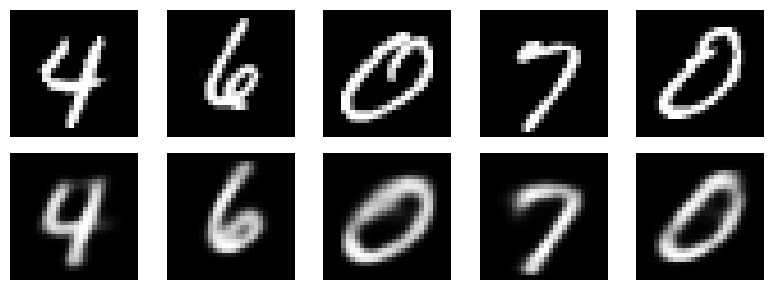

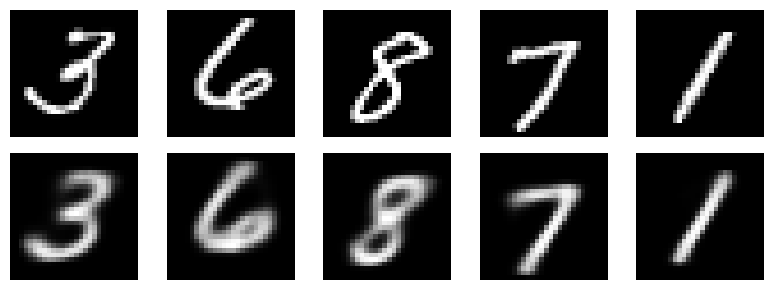

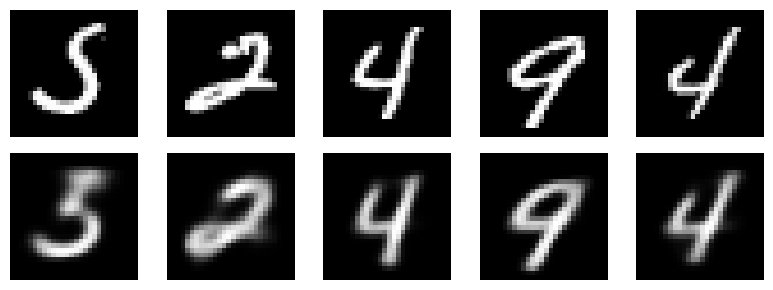

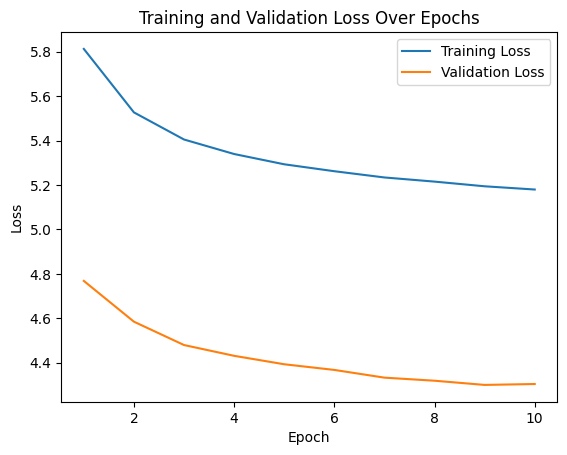

Epoch [10/10], 
Training loss: 5.1798, 
Validation loss: 4.3041


In [ ]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, train_loader, val_loader, 10)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

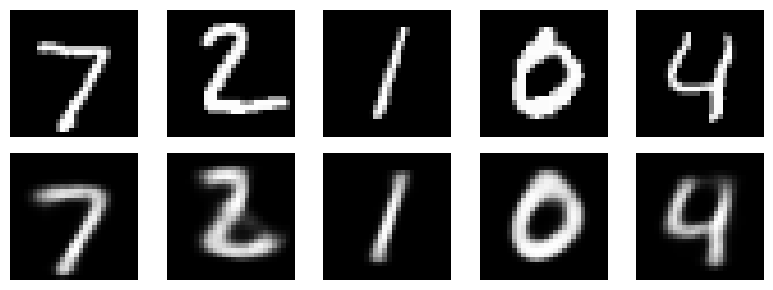

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for X_batch, y in val_loader:
        X_batch = X_batch[:5]
        X_batch = X_batch.float().to(device)
        mu, log_var, reconstruction = autoencoder(X_batch)
        compare_pictures_vae(X_batch, reconstruction)
        break

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
mu = torch.tensor(np.array([np.random.normal(0, 1, latent_features) for i in range(10)])).float().to(device)

In [ ]:
# в режиме eval log_var не учитывается, аоэтому инициализируем переменную случайными числами
log_var = torch.tensor(np.random.rand(10, latent_features)).float().to(device)

In [ ]:
def show_pictures(pictures):
    rows = ceil(len(pictures)/5)
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.flatten()
    for i, photo in enumerate(pictures):
        photo = photo.view(28, 28)
        photo = photo.detach().cpu()
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

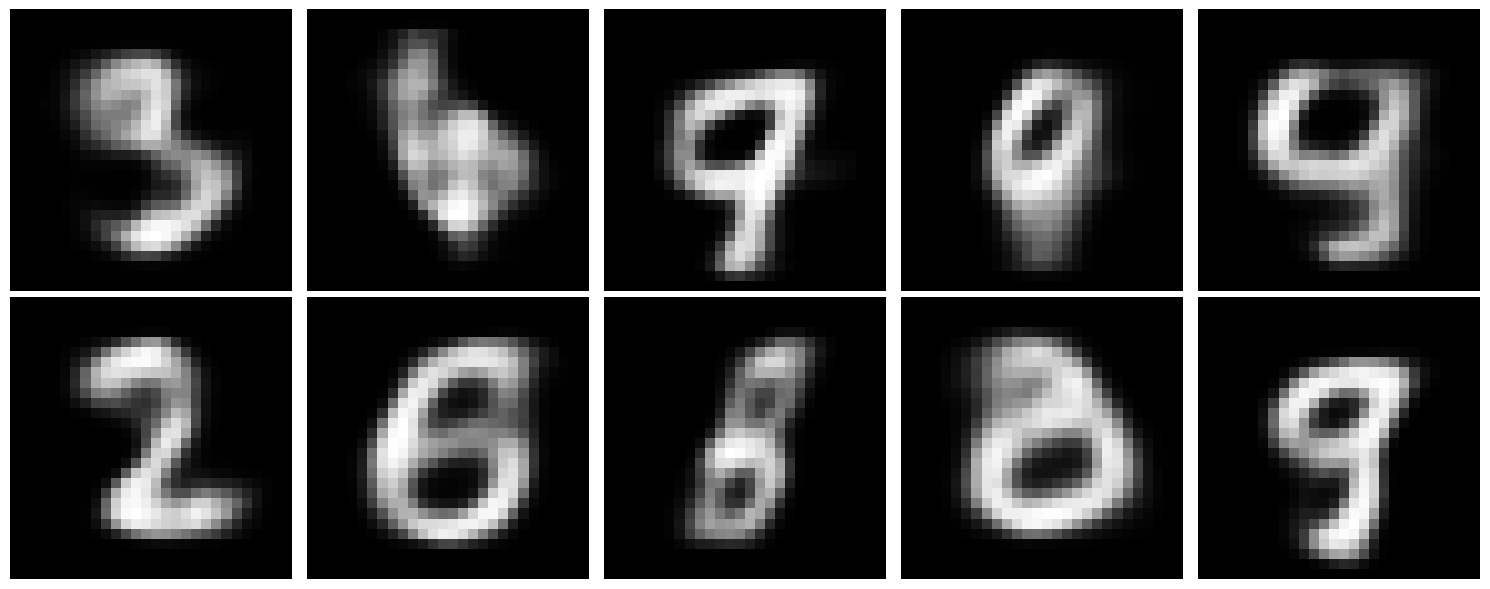

In [ ]:
generated_pictures = autoencoder.decode(mu, log_var)
show_pictures(generated_pictures)


## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Также покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
autoencoder.eval()
all_latent = np.empty((0, 20))
with torch.no_grad():
    for X_batch, y in val_loader:
        X_batch = X_batch.float().to(device)
        mu, log_var, reconstruction = autoencoder(X_batch)
        z = autoencoder.gaussian_sampler(mu, log_var).detach().cpu().numpy()
        all_latent = np.concatenate((all_latent, z), axis=0)

In [ ]:
all_latent.shape

(10000, 20)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
latent_two_dim = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_latent)

In [ ]:
latent_two_dim.shape

(10000, 2)

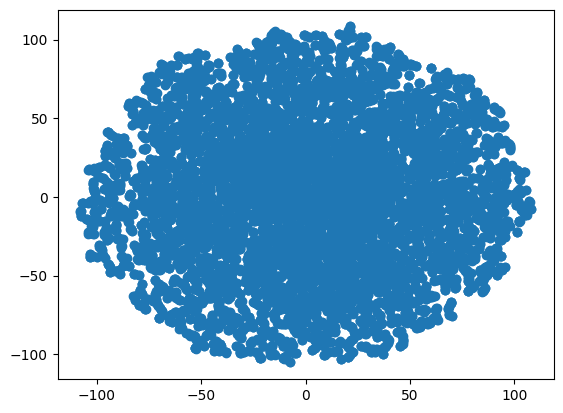

In [ ]:
plt.scatter(latent_two_dim[:,0], latent_two_dim[:,1])

--------------------------------------------------------------------------------

In [ ]:
autoencoder.eval()
all_latent = np.empty((0, 20))
classes = np.array([])
with torch.no_grad():
    for X_batch, y in val_loader:
        X_batch = X_batch.float().to(device)
        mu, log_var, reconstruction = autoencoder(X_batch)
        z = autoencoder.gaussian_sampler(mu, log_var).detach().cpu().numpy()
        all_latent = np.concatenate((all_latent, z), axis=0)
        y = y.detach().cpu().numpy()
        classes = np.concatenate((classes, y), axis=0)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
latent_two_dim = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_latent)

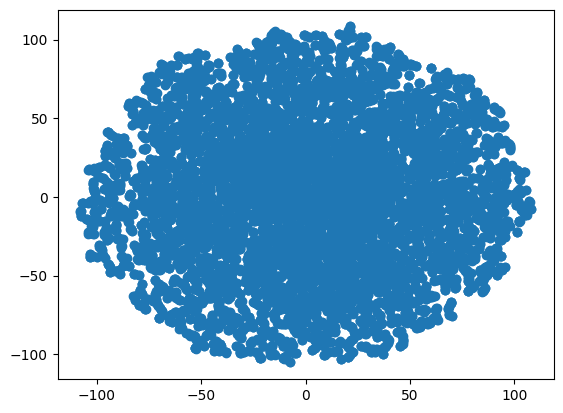

In [ ]:
plt.scatter(latent_two_dim[:,0], latent_two_dim[:,1])

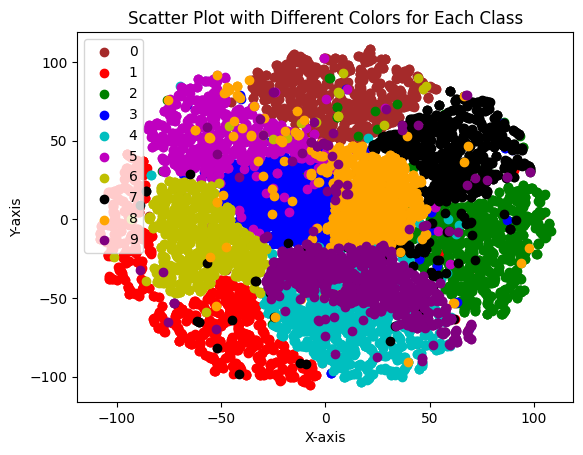

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # You can customize colors as needed

# Create a scatter plot with different colors for each class
for class_label in np.unique(classes):
    plt.scatter(latent_two_dim[:,0][classes == class_label], latent_two_dim[:,1][classes == class_label], label=f'{int(class_label)}', c=colors[int(class_label) - 1])

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.title('Scatter Plot with Different Colors for Each Class')
plt.show()

## 2.3. Conditional VAE


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



# Загрузка данных

При загрузке использрем трансформеры. Переводим картинку в тензор, убираем единичную размерность. Метки классов кодируем с помощью OHE.

In [ ]:
train_dataset = datasets.MNIST(root = './cva_mnist_data/',
                               train = True,
                               transform = Compose([ToTensor(),
                                                    Lambda(lambda x: torch.squeeze(x))]),
                               target_transform = Lambda(lambda x: F.one_hot(torch.tensor(x), 10)),
                               download = True)

val_dataset = datasets.MNIST(root = './cva_mnist_data/',
                               train = False,
                               transform = Compose([ToTensor(),
                                                    Lambda(lambda x: torch.squeeze(x))]),
                               target_transform = Lambda(lambda x: F.one_hot(torch.tensor(x), 10)),
                               download = False)

In [ ]:
batch_size = 60
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Создание класса модели

Особенностью работы Conditional VAE являет подача метки класса на декодер. Для этого в методе decode сконкатенируем OHE векторы с метками классов, а в декодере изменим input

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_size=20, num_of_classes=10):
        super(CVAE, self).__init__()
        self.num_of_classes = num_of_classes
        self.flatten = nn.Flatten()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28*1, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=self.latent_size*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_size + num_of_classes, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=28*28*1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = x.view(-1, 2, self.latent_size)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        sd = torch.exp(0.5 * log_var)
        return mu, sd

    def gaussian_sampler(self, mu, sd):
        if self.training:
            z = torch.randn_like(sd)
            x = z * sd + mu
            return x
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, mu, sd, y):
        x = self.gaussian_sampler(mu, sd)
        x = torch.cat((x, y), dim=1)
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x, y):
        mu, sd = self.encode(x)
        reconstructed = self.decode(mu, sd, y).view(-1, 28, 28)
        return mu, sd, reconstructed

# Создадим функцию потерь

In [ ]:
def log_likelihood(x, reconstructed):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstructed, x)

def KL_divergence(mu, sd):
    loss = -0.5 * torch.sum(1 + torch.log(sd**2) - mu**2 - sd**2)
    return loss

def loss_cvae(x, reconstructed, mu, sd):
    return (KL_divergence(mu, sd) + log_likelihood(x, reconstructed))/2/28/28

# Инициализируем модель, функцию потерь, оптимизатор

In [ ]:
LATENT_SIZE = 20
NUM_CLASSES = 10
cvae = CVAE(LATENT_SIZE, NUM_CLASSES)
criterion = loss_cvae
optimizer = torch.optim.Adam(params=cvae.parameters())

## Функции для визуального контроля за обучаением модели

In [ ]:
def compare_pictures_vae(gt, rec):
    """
    Функция получает на вход ихсодные картинки и восстановленные картинки, вытянутые в векторы.
    Выводит соответствующие изображения, одно под другим
    """
    rec = rec.cpu().detach().numpy()
    gt = gt.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(8, 3))
    axes = axes.flatten()
    for i, photo in enumerate(np.concatenate([gt, rec])):
        photo = np.clip(photo, 0, 1)
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def losses_chart(train_losses, val_losses):
    """
    Функция получает списки лоссов на трейне и валидации и отрисовывает графики
    """
    epoch = len(train_losses)
    plt.plot(range(1, epoch + 1), train_losses, label = 'Training Loss')
    plt.plot(range(1, epoch + 1), val_losses, label = 'Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Функция для обучения модели

In [ ]:
def train_cvae(model, loss_fn, optimizer, train_loader, val_loader, n_epochs):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss_per_epoch, val_loss_per_epoch = [], []
        model.train()
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            mu, sd, reconstructed = model(X, y)
            loss = loss_fn(X, reconstructed, mu, sd)
            loss.backward()
            optimizer.step()
            train_loss_per_epoch.append(loss.detach().cpu().item())
        train_loss = sum(train_loss_per_epoch) / len(train_loss_per_epoch)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                X = X.to(device)
                y = y.to(device)
                mu, sd, reconstructed = model(X, y)
                loss = loss_fn(X, reconstructed, mu, sd)
                val_loss_per_epoch.append(loss.detach().cpu().item())
        val_loss = sum(val_loss_per_epoch) / len(val_loss_per_epoch)
        val_losses.append(val_loss)

        display.clear_output(wait=True) # clear previous output
        for i in range(0, 11, 5):
            compare_pictures_vae(X[i:i+5], reconstructed[i:i+5])
        losses_chart(train_losses, val_losses)
        print(f"Epoch [{epoch + 1}/{n_epochs}],",
              f"\nTraining loss: {np.mean(train_loss):.4f},",
              f"\nValidation loss: {np.mean(val_loss):.4f}")

    return train_losses, val_losses


# Обучение модели

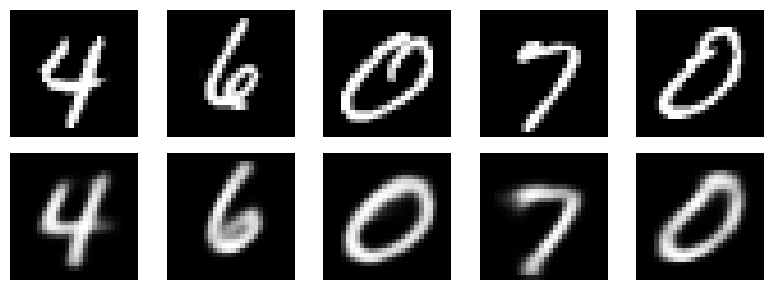

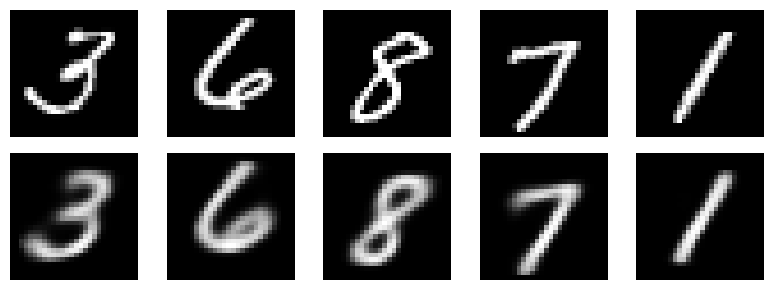

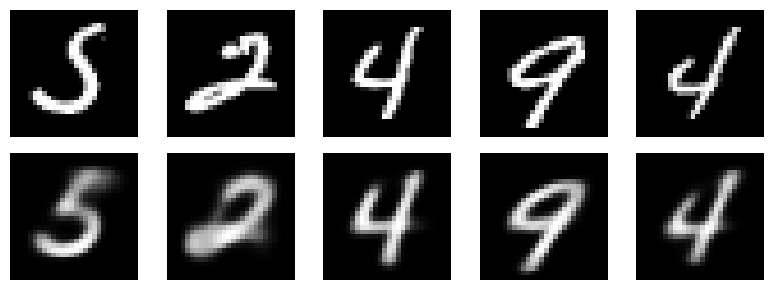

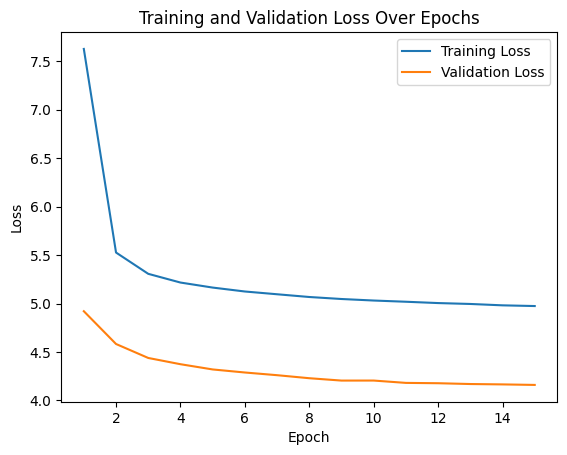

Epoch [15/15], 
Training loss: 4.9740, 
Validation loss: 4.1601


In [ ]:
train_losses, val_losses = train_cvae(cvae, criterion, optimizer, train_loader, val_loader, 15)

In [ ]:
torch.save(cvae, 'cvae.pt')

In [ ]:
device = 'cpu:0' if torch.cuda.is_available() else 'cpu'
cvae = torch.load('cvae.pt').to(device)

### Sampling


Передадим декодеру случайно сгенерированные из нормального распределения векторы. Вектор стандартных отклонений в режиме eval не задействован, он нужен только чтобы запустить inference. Попробуем также построить на одних и тех же векторах латентного пространства разные числа, передав разные метки класса.

In [ ]:
num_pictures = 10
mu = torch.tensor(np.array([np.random.normal(0, 1, LATENT_SIZE) for i in range(num_pictures)])).float().to(device)
sd = torch.tensor(np.array([np.random.normal(0, 1, LATENT_SIZE) for i in range(num_pictures)])).float().to(device)
y_5 = F.one_hot(torch.tensor([5 for _ in range(num_pictures)]), num_classes=10).float().to(device)
y_7 = F.one_hot(torch.tensor([7 for _ in range(num_pictures)]), num_classes=10).float().to(device)

In [ ]:
cvae.eval()
with torch.no_grad():
    reconstructed_5 = cvae.decode(mu, sd, y_5).view(-1, 28, 28).cpu()
    reconstructed_7 = cvae.decode(mu, sd, y_7).view(-1, 28, 28).cpu()

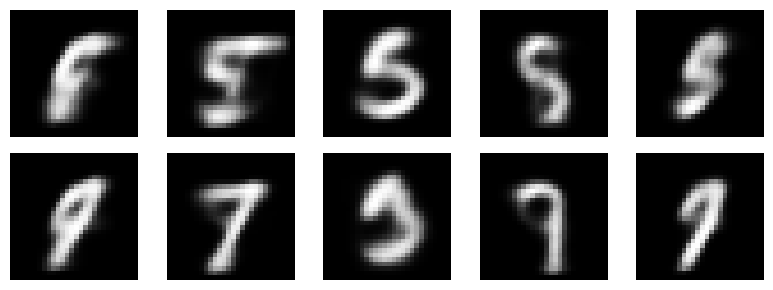

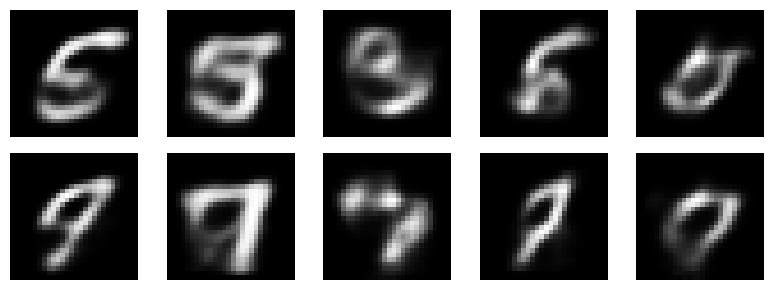

In [ ]:
for i in range(0, 6, 5):
    compare_pictures_vae(reconstructed_5[i:i+5], reconstructed_7[i:i+5])

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
cvae.eval()
cvae.to(device)
all_latent = np.empty((0, LATENT_SIZE))
classes = np.array([])
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        y = torch.argmax(y, dim=1).cpu().numpy()
        mu, _ = cvae.encode(X)
        mu = mu.cpu().numpy()
        all_latent = np.concatenate((all_latent, mu), axis=0)
        classes = np.concatenate((classes, y), axis=0)

In [ ]:
latent_two_dim = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_latent)

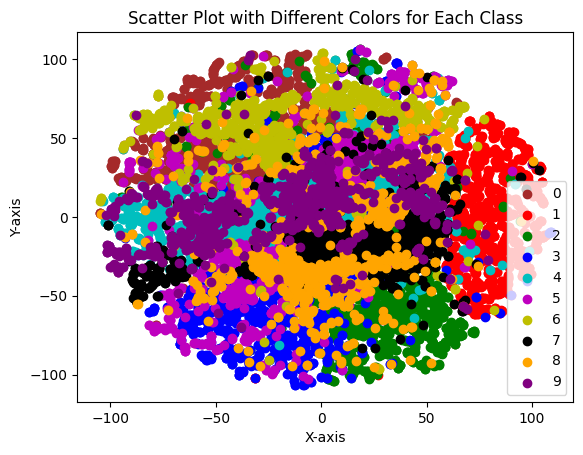

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for class_label in np.unique(classes):
    plt.scatter(latent_two_dim[classes==class_label][:,0], latent_two_dim[classes==class_label][:,1], c=colors[int(class_label)-1], label=f'{int(class_label)}')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.title('Scatter Plot with Different Colors for Each Class')
plt.show()

По сравнению с VAE видим больший разброс облаков классов относительно центров скоплений. Скорее всего это объясняется тем, что уже после преобразования векторов среднего и стандартного отклонения модели подается класс изображения, что в ряде случаев заставляет модель поменять предсказание.

# Вывод

В ходе работы были построены три автоенкодера: обычные AE, вариационный и вариационный с подачей меток классов (conditional).

AE позволил восстановить картинки лиц из сжатого (латентного пространства), позволил выделить "вектор улыбки" и создать новые изображения путем изменения входных данных.

VAE используется для более компактного отображения данных одного вида в латентное пространство. Результат отображения в латентном пространстве был выведен графически для контроля работы VAE.

CVAE позволяет подавать на вход декодеру метку класса, тем самым подсказывая (указывая), какой результат мы хотим получить. Благодаря этому можно получать разные результаты на одних латентных векторах. Эта особенность также влияет и на качество группировки данных в латентном пространстве.